# Credit Scorecard Project – Scorecard Build

## 1. Load Final Model and Scoring Data

In [1]:
# pip install -r ../requirements_sagemaker_localised.txt

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt

import joblib
import pickle


pd.options.display.float_format = '{:.4f}'.format

In [3]:
# Features of the final model

with open("../artifacts/logreg_final_features.txt", "r") as file:
    lines = file.readlines()

    FEATURES=[]
    for line in lines:
        feature = line.strip()
        FEATURES.append(feature)

print(len(FEATURES))
FEATURES

17


['annual_inc_woe',
 'fico_range_low_woe',
 'inq_last_6mths_woe',
 'mths_since_rcnt_il_woe',
 'bc_open_to_buy_woe',
 'mo_sin_old_rev_tl_op_woe',
 'mo_sin_rcnt_tl_woe',
 'mort_acc_woe',
 'mths_since_recent_bc_woe',
 'num_rev_tl_bal_gt_0_woe',
 'emp_length_num_woe',
 'home_ownership_grouped_woe',
 'verification_status_woe',
 'addr_state_grouped_woe',
 'purpose_woe',
 'F_OVERLIMIT_woe',
 'f_collections_12_mths_ex_med_gt0_woe']

In [4]:
# Read training data
df_train = pd.read_csv('../data/processed/train_woe.csv')
df_test = pd.read_csv('../data/processed/test_woe.csv')

X_train = df_train[FEATURES]
y_train = df_train['GB_FLAG']

X_test = df_test[FEATURES]
y_test = df_test['GB_FLAG']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(1074238, 17) (1074238,)
(205520, 17) (205520,)


In [5]:
# Load the final pipeline (StandardScaler + LogisticRegression)
pipe = joblib.load('../models/logistic/final_model_pipeline.pkl')

scaler=pipe.named_steps["scaler"]
model=pipe.named_steps["clf"]

In [6]:
# Get coefficients and intercept
coef = model.coef_[0]
intercept = model.intercept_[0]

coefs_df = pd.DataFrame({
    "feature": FEATURES,
    "coef": coef
})

coefs_df

,feature,coef
0,annual_inc_woe,-0.1175
1,fico_range_low_woe,-0.1950
2,inq_last_6mths_woe,-0.0971
3,mths_since_rcnt_il_woe,-0.1418
4,bc_open_to_buy_woe,-0.1376
5,mo_sin_old_rev_tl_op_woe,0.0615
6,mo_sin_rcnt_tl_woe,-0.0792
7,mort_acc_woe,-0.0600
8,mths_since_recent_bc_woe,-0.0784
9,num_rev_tl_bal_gt_0_woe,-0.1701


## 2. Score Mapping

In [7]:
# Define scoring parameters 

def score_conversion(log_odds):
    # Define Scorecard scale parameters
    PDO = 50                # Points to double the odds
    base_odds = 50           # Base odds = good : bad
    base_score = 500        # Score at base odds

    # Compute factor and offset
    factor = PDO / np.log(2)
    offset = base_score - factor * np.log(base_odds)

    # convert log-odds to score
    score = offset - factor * log_odds
    return score

In [8]:
# Get raw log-odds from the model
proba_train =  pipe.predict_proba(X_train)[:, 1]
log_odds_train = pipe.predict_log_proba(X_train)[:, 1] / pipe.predict_proba(X_train)[:, 0]

# Score conversion
score = score_conversion(log_odds_train)

df_train['score'] = score
df_train['score'].describe().apply(lambda x: format(x, '0.5f'))

count    1074238.00000
mean         370.11695
std           27.14064
min          302.54085
25%          350.35412
50%          365.95198
75%          385.60839
max          517.05669
Name: score, dtype: object

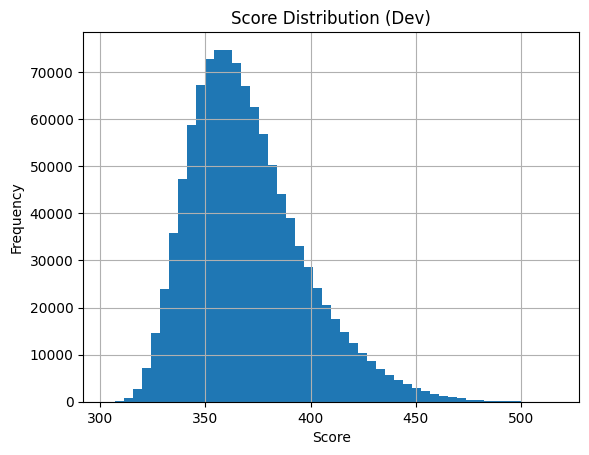

In [9]:
# Check distribution of the scores

df_train['score'].hist(bins=50)
plt.title("Score Distribution (Dev)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

## 3. Score Binning (Dev Sample)

### 3.1 Equal-width Bins

In [10]:
# Equal-width binning
num_bins = 10  
cut_bins = pd.cut(df_train['score'], bins=num_bins)
df_train['bin_eq_width'] = pd.cut(df_train['score'], bins=num_bins, labels=False)

summary_cut = df_train.groupby(cut_bins).agg(
    count=('GB_FLAG', 'count'),
    bad_rate=('GB_FLAG', 'mean'),
    min_score=('score', 'min'),
    max_score=('score', 'max')
).reset_index()

summary_cut['pctg'] = summary_cut['count'] / df_train.shape[0]
summary_cut['bin_type'] = 'Equal-width'

col_order = ['count', 'pctg', 'bad_rate', 'min_score', 'max_score']
summary_cut = summary_cut.reindex(columns=col_order)
summary_cut


/var/folders/22/9hdsbk0j58z1r2x79bx2zjh80000gn/T/ipykernel_8235/3868483788.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_cut = df_train.groupby(cut_bins).agg(


,count,pctg,bad_rate,min_score,max_score
0,10684,0.0099,0.4556,302.5408,323.9924
1,180408,0.1679,0.3255,323.9924,345.4440
2,361270,0.3363,0.2317,345.4441,366.8955
3,280830,0.2614,0.1585,366.8958,388.3470
4,145352,0.1353,0.1096,388.3474,409.7981
5,63541,0.0591,0.0709,409.7989,431.2503
6,23943,0.0223,0.0443,431.2510,452.6999
7,6839,0.0064,0.0254,452.7032,474.1401
8,1269,0.0012,0.0197,474.1637,495.5840
9,102,0.0001,0.0196,495.6966,517.0567


### 3.2 Equal-Frequency Bins

In [11]:
# Equal-frequency binning
qcut_bins = pd.qcut(df_train['score'], q=10, duplicates='drop')  # avoids errors if quantiles aren't unique

summary_qcut = df_train.groupby(qcut_bins).agg(
    count=('GB_FLAG', 'count'),
    bad_rate=('GB_FLAG', 'mean'),
    min_score=('score', 'min'),
    max_score=('score', 'max')
).reset_index()

summary_qcut['pctg'] = summary_qcut['count'] / df_train.shape[0]
summary_qcut['bin_type'] = 'Equal-frequency'

summary_qcut = summary_qcut.reindex(columns=col_order)
summary_qcut


/var/folders/22/9hdsbk0j58z1r2x79bx2zjh80000gn/T/ipykernel_8235/1582572224.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_qcut = df_train.groupby(qcut_bins).agg(


,count,pctg,bad_rate,min_score,max_score
0,107424,0.1000,0.3619,302.5408,339.0318
1,107424,0.1000,0.2917,339.0319,347.0181
2,107424,0.1000,0.2567,347.0181,353.5215
3,107423,0.1000,0.2293,353.5215,359.6867
4,107424,0.1000,0.2040,359.6868,365.9519
5,107424,0.1000,0.1798,365.9520,372.8643
6,107423,0.1000,0.1584,372.8644,380.8283
7,107424,0.1000,0.1340,380.8284,391.1659
8,107424,0.1000,0.1082,391.1659,407.2510
9,107424,0.1000,0.0633,407.2511,517.0567


### 3.3 Comparing the Binning Approach

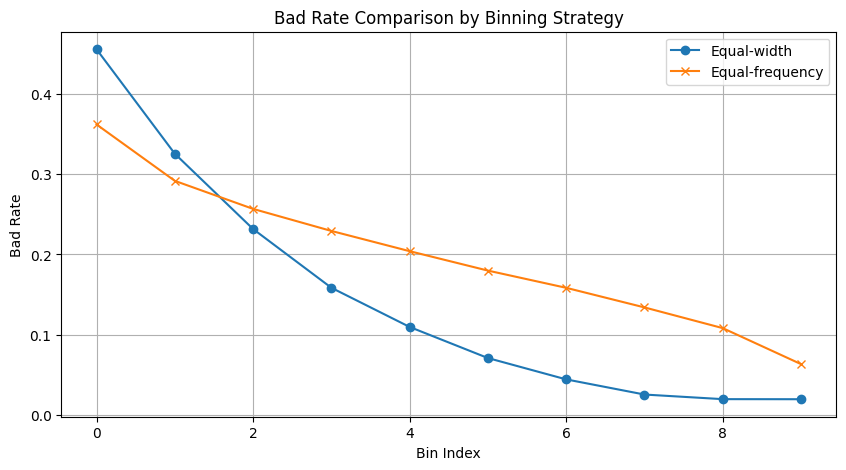

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(summary_cut['bad_rate'], label='Equal-width', marker='o')
plt.plot(summary_qcut['bad_rate'], label='Equal-frequency', marker='x')
plt.title('Bad Rate Comparison by Binning Strategy')
plt.xlabel('Bin Index')
plt.ylabel('Bad Rate')
plt.legend()
plt.grid(True)
plt.show()

### 3.4 Hybrid Binning

Using bins from the equal-width binning as the base by merging bins with population of less than 2% (bin 0, 1, 2 and bin 9).

In [13]:
# Merge small bins

bin_merge_map = {
    0: 0,
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 5,
    8: 5,
    9: 5
}

# Apply the mapping to create new bin column
df_train['new_bin'] = df_train['bin_eq_width'].map(bin_merge_map)

summary_new = df_train.groupby(df_train['new_bin']).agg(
    count=('GB_FLAG', 'count'),
    bad_rate=('GB_FLAG', 'mean'),
    min_score=('score', 'min'),
    max_score=('score', 'max')
).reset_index()

summary_new['pctg'] = summary_new['count'] / df_train.shape[0]
summary_new['bin_type'] = 'Equal-width (merged)'

summary_new = summary_new.reindex(columns=col_order)
summary_new

,count,pctg,bad_rate,min_score,max_score
0,191092,0.1779,0.3328,302.5408,345.4440
1,361270,0.3363,0.2317,345.4441,366.8955
2,280830,0.2614,0.1585,366.8958,388.3470
3,145352,0.1353,0.1096,388.3474,409.7981
4,63541,0.0591,0.0709,409.7989,431.2503
5,32153,0.0299,0.0392,431.2510,517.0567


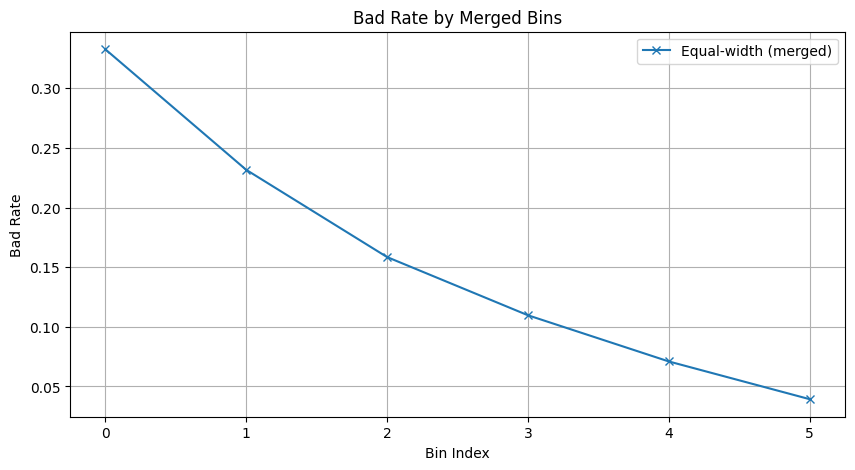

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(summary_new['bad_rate'], label='Equal-width (merged)', marker='x')
plt.title('Bad Rate by Merged Bins')
plt.xlabel('Bin Index')
plt.ylabel('Bad Rate')
plt.legend()
plt.grid(True)
plt.show()

Bin 4 consists of 33.6% of the population and bin 5 17.8% - too braod for the higher risk end of the population.

Will split bin 4 into 3 smaller bins and bin 5 into 2 bins roughly following the thresholds proposed by the equal-frequency strategy.

,hybrid_bin,count,pctg,bad_rate,min_score,max_score
0,0,24020,0.0224,0.4290,302.5408,327.9997
1,1,43990,0.0409,0.3560,328.0003,334.9999
2,2,116578,0.1085,0.3068,335.0003,344.9999
3,3,163246,0.1520,0.2585,345.0000,355.0000
4,4,173368,0.1614,0.2155,355.0002,365.0000
5,5,154080,0.1434,0.1784,365.0000,374.9999
6,6,173588,0.1616,0.1440,375.0002,389.9998
7,7,126153,0.1174,0.1083,390.0001,408.9999
8,8,66642,0.0620,0.0715,409.0002,430.9993
9,9,32573,0.0303,0.0396,431.0000,517.0567


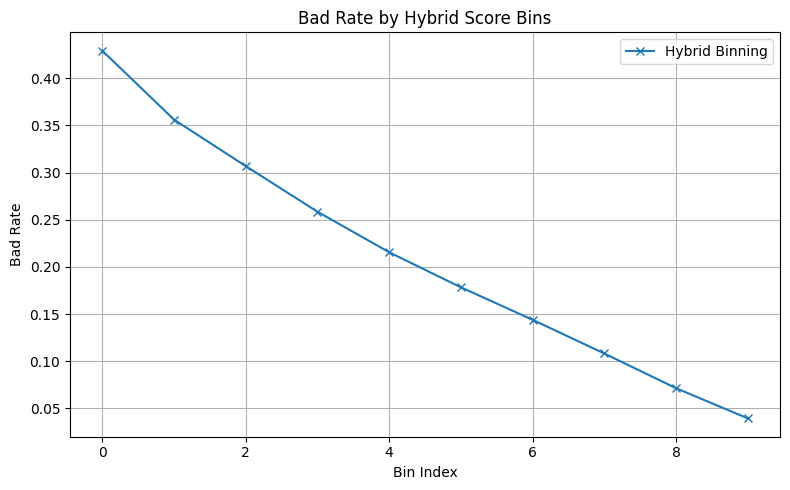

In [15]:
# Define full bin edges
bin_edges = [300, 328, 335, 345, 355, 365, 375, 390, 409, 431, 518]
 
# Assign bin labels based on full set of bin edges
df_train['hybrid_bin'] = pd.cut(df_train['score'], bins=bin_edges, include_lowest=True, right=False, labels=False)


# Create a summary table
summary_hybrid = (
    df_train.groupby(df_train['hybrid_bin']).agg(
          count=('GB_FLAG', 'count'),
          pctg=('GB_FLAG', lambda x: round(len(x) / len(df_train), 4)),
          bad_rate=('GB_FLAG', 'mean'),
          min_score=('score', 'min'),
          max_score=('score', 'max')
      )
      .reset_index()
)

# Display summary
display(summary_hybrid)

# Plot bad rate by bin
plt.figure(figsize=(8, 5))
plt.plot(summary_hybrid['hybrid_bin'], summary_hybrid['bad_rate'], marker='x', label='Hybrid Binning')
plt.title('Bad Rate by Hybrid Score Bins')
plt.xlabel('Bin Index')
plt.ylabel('Bad Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**With customer binning:**
* All bins are above 2% population, meeting the usual minimum bin size threshold.
* The spacing is not strictly equal-frequency, but bad rate is monotonic and smoothly decreasing.

## 4. Score & Binning (OOT Sampling)

In [16]:
# Get raw log-odds for the OOT data
proba_test =  pipe.predict_proba(X_test)[:, 1]
log_odds_test = pipe.predict_log_proba(X_test)[:, 1] / pipe.predict_proba(X_test)[:, 0]

# Score conversion
score_test = score_conversion(log_odds_test)

df_test['score'] = score_test
df_test['score'].describe().apply(lambda x: format(x, '0.5f'))

count    205520.00000
mean        368.62679
std          28.50302
min         305.51396
25%         347.27288
50%         363.81728
75%         385.41376
max         511.73533
Name: score, dtype: object

In [17]:
# Apply Dev score binning thresholds to OOT
bin_edges = [300, 328, 335, 345, 355, 365, 375, 390, 409, 431, 518]

# Assign bin label to each OOT score
df_test["score_bin"] = pd.cut(
    df_test["score"], 
    bins=bin_edges, 
    labels=False, 
    include_lowest=True, 
    right=False
)

In [18]:
summary_test = (
    df_test.groupby(df_test['score_bin']).agg(
          count=('GB_FLAG', 'count'),
          pctg=('GB_FLAG', lambda x: round(len(x) / len(df_test), 4)),
          bad_rate=('GB_FLAG', 'mean'),
          min_score=('score', 'min'),
          max_score=('score', 'max')
      )
      .reset_index()
)

display(summary_test)

,score_bin,count,pctg,bad_rate,min_score,max_score
0,0,6659,0.0324,0.4338,305.5140,327.9997
1,1,11528,0.0561,0.3584,328.0004,334.9988
2,2,26257,0.1278,0.3041,335.0008,344.9997
3,3,31313,0.1524,0.2565,345.0009,354.9998
4,4,30462,0.1482,0.2172,355.0002,365.0000
5,5,26263,0.1278,0.1842,365.0011,374.9999
6,6,29564,0.1438,0.1550,375.0002,389.9999
7,7,23376,0.1137,0.1149,390.0006,408.9985
8,8,13375,0.0651,0.0767,409.0006,430.9965
9,9,6723,0.0327,0.0464,431.0022,511.7353


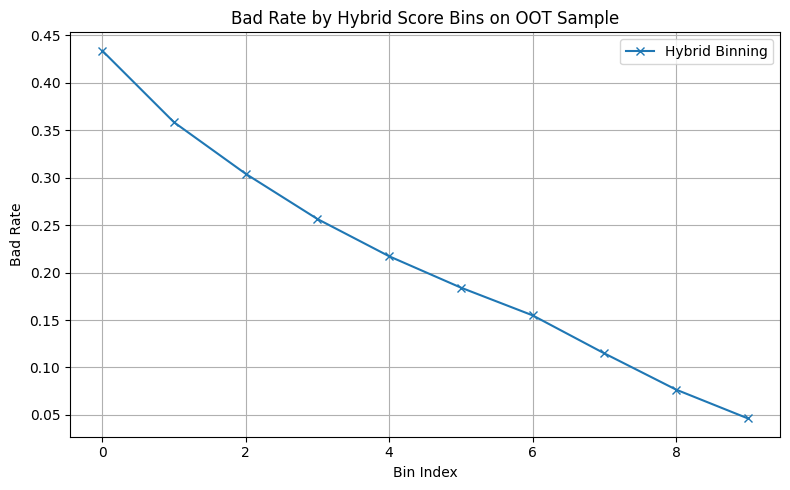

In [19]:
# Plot bad rate by bin
plt.figure(figsize=(8, 5))
plt.plot(summary_test['score_bin'], summary_test['bad_rate'], marker='x', label='Hybrid Binning')
plt.title('Bad Rate by Hybrid Score Bins on OOT Sample')
plt.xlabel('Bin Index')
plt.ylabel('Bad Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Stability Check

### 5.1 AUC/ KS

In [20]:
# AUC
auc_dev = roc_auc_score(y_train, proba_train)
auc_oot = roc_auc_score(y_test, proba_test)

# KS
def compute_ks(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    return max(tpr - fpr)

ks_dev = compute_ks(y_train, proba_train)
ks_oot = compute_ks(y_test, proba_test)

print("AUC (Dev):", round(auc_dev, 4), 
      "\nAUC (OOT):", round(auc_oot, 4),
      "\nKS (Dev):", round(ks_dev, 4), 
      "\nKS (OOT):", round(ks_oot, 4)
      )

AUC (Dev): 0.6537 
AUC (OOT): 0.6527 
KS (Dev): 0.2207 
KS (OOT): 0.219


**Conclusion:**

* AUC ~0.65 is reasonable for scorecard models in financial contexts — it means the model distinguishes bads from goods 65% of the time, which is quite serviceable, especially given that only application data is used.
* KS ~0.22 is also decent — in production, values >0.2 are typically considered acceptable for credit scoring models in low-to-mid risk portfolios.
* Stability: The fact that your OOT performance is almost identical to Dev suggests:
	* the score-to-outcome relationship is generalizing well.
	* No overfitting
	* No major distribution shift between Dev and OOT.


### 5.2 Score Distribution

In [21]:
score_stats_dev = df_train['score'].describe()
score_stats_oot = df_test['score'].describe()

pd.DataFrame({'Dev': score_stats_dev, 'OOT': score_stats_oot})

,Dev,OOT
count,1074238.0000,205520.0000
mean,370.1169,368.6268
std,27.1406,28.5030
min,302.5408,305.5140
25%,350.3541,347.2729
50%,365.9520,363.8173
75%,385.6084,385.4138
max,517.0567,511.7353


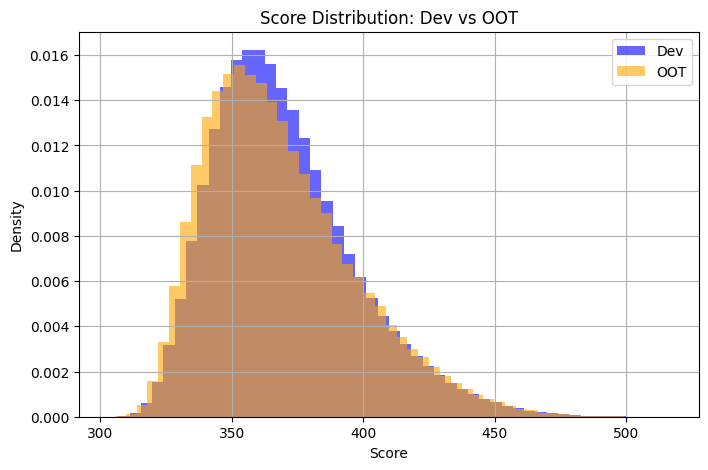

In [22]:
# Compare score distribution between Dev and OOT sample

plt.figure(figsize=(8,5))
plt.hist(df_train['score'], bins=50, alpha=0.6, label='Dev', color='blue', density=True)
plt.hist(df_test['score'], bins=50, alpha=0.6, label='OOT', color='orange', density=True)
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Score Distribution: Dev vs OOT')
plt.legend()
plt.grid(True)
plt.show()

* Score distribution between Dev and OOT is consistent, with only a slight leftward skew in the OOT set, which aligns with the known ~1% higher bad rate.
* Both the distribution plot and the descriptive stats table clearly support this conclusion.

### 5.3 Score banding & PSI

In [23]:
banding_sumy = summary_hybrid[['hybrid_bin','pctg', 'bad_rate']]
banding_sumy = banding_sumy.rename(columns={'hybrid_bin': 'score_band', 'pctg' : 'band_size_dev', 'bad_rate':'bad_rate_dev'})

banding_sumy['band_size_oot'] = summary_test['pctg']
banding_sumy['bad_rate_oot'] = summary_test['bad_rate']

banding_sumy

,score_band,band_size_dev,bad_rate_dev,band_size_oot,bad_rate_oot
0,0,0.0224,0.4290,0.0324,0.4338
1,1,0.0409,0.3560,0.0561,0.3584
2,2,0.1085,0.3068,0.1278,0.3041
3,3,0.1520,0.2585,0.1524,0.2565
4,4,0.1614,0.2155,0.1482,0.2172
5,5,0.1434,0.1784,0.1278,0.1842
6,6,0.1616,0.1440,0.1438,0.1550
7,7,0.1174,0.1083,0.1137,0.1149
8,8,0.0620,0.0715,0.0651,0.0767
9,9,0.0303,0.0396,0.0327,0.0464


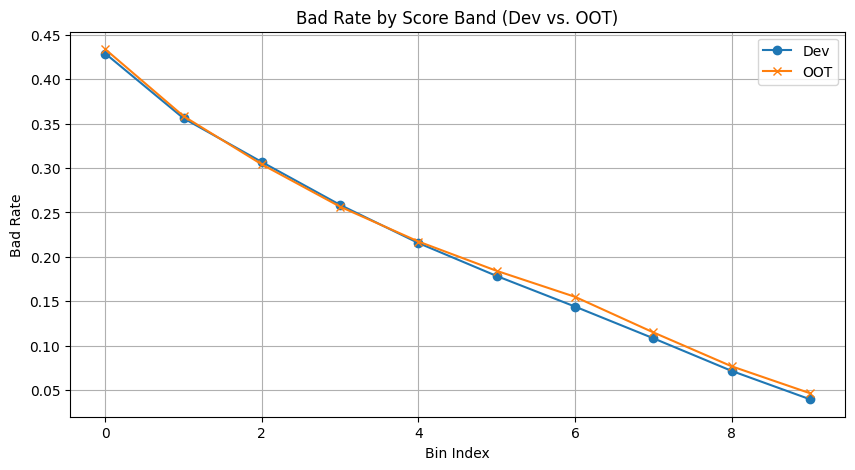

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(summary_hybrid['bad_rate'], label='Dev', marker='o')
plt.plot(summary_test['bad_rate'], label='OOT', marker='x')
plt.title('Bad Rate by Score Band (Dev vs. OOT)')
plt.xlabel('Bin Index')
plt.ylabel('Bad Rate')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Calculate PSI 
def calculate_psi(expected, actual):
    epsilon = 1e-6  # to avoid divide by zero
    expected = np.array(expected) + epsilon
    actual = np.array(actual) + epsilon
    psi = (actual - expected) * np.log(actual / expected)
    return np.sum(psi)

psi_score = calculate_psi(banding_sumy["band_size_dev"], banding_sumy["band_size_oot"])
print(f"PSI = {psi_score:.4f}")

PSI = 0.0171


PSI Value Interpretation
* ✅ < 0.10:  No significant population shift — model is stable
* 🟨 0.10–0.25: Moderate shift — worth monitoring
* 🔴 > 0.25: Significant shift — investigate further


Population Stability Index (PSI) between the development and OOT samples was 0.0171, indicating excellent stability and minimal distribution shift in score predictions.

This suggests the model remains robust when applied to new data.

### 5.4 Cumulative Gain/ Lift

In [42]:
# Sort by ascending score
df_test_sorted = df_test.sort_values(by='score', ascending=True)

# Add Decile 
df_test_sorted['score_decile'] = pd.qcut(df_test_sorted['score'], q=10, labels=False) + 1 

# Bad by Decile  
summary = df_test_sorted.groupby('score_decile').agg(
    total_obs=('GB_FLAG', 'count'),
    bads=('GB_FLAG', 'sum')
).reset_index()

# Calculate cumulative bads by band 
summary['cum_bads'] = summary['bads'].cumsum()
summary['cum_total'] = summary['total_obs'].cumsum()


# Calcuate cumulative gain and lift 
total_bads = summary['bads'].sum()
total_obs = summary['total_obs'].sum()

summary['gain'] = summary['cum_bads'] / total_bads
summary['cum_pct_pop'] = summary['cum_total'] / total_obs
summary['lift'] = summary['gain'] / summary['cum_pct_pop']

summary



,score_decile,total_obs,bads,cum_bads,cum_total,gain,cum_pct_pop,lift
0,1,20552,7747.0000,7747.0000,20552,0.1798,0.1000,1.7976
1,2,20552,6243.0000,13990.0000,41104,0.3246,0.2000,1.6231
2,3,20552,5624.0000,19614.0000,61656,0.4551,0.3000,1.5171
3,4,20552,4908.0000,24522.0000,82208,0.5690,0.4000,1.4225
4,5,20552,4434.0000,28956.0000,102760,0.6719,0.5000,1.3438
5,6,20552,3904.0000,32860.0000,123312,0.7625,0.6000,1.2708
6,7,20552,3513.0000,36373.0000,143864,0.8440,0.7000,1.2057
7,8,20552,3020.0000,39393.0000,164416,0.9141,0.8000,1.1426
8,9,20552,2321.0000,41714.0000,184968,0.9679,0.9000,1.0755
9,10,20552,1382.0000,43096.0000,205520,1.0000,1.0000,1.0000


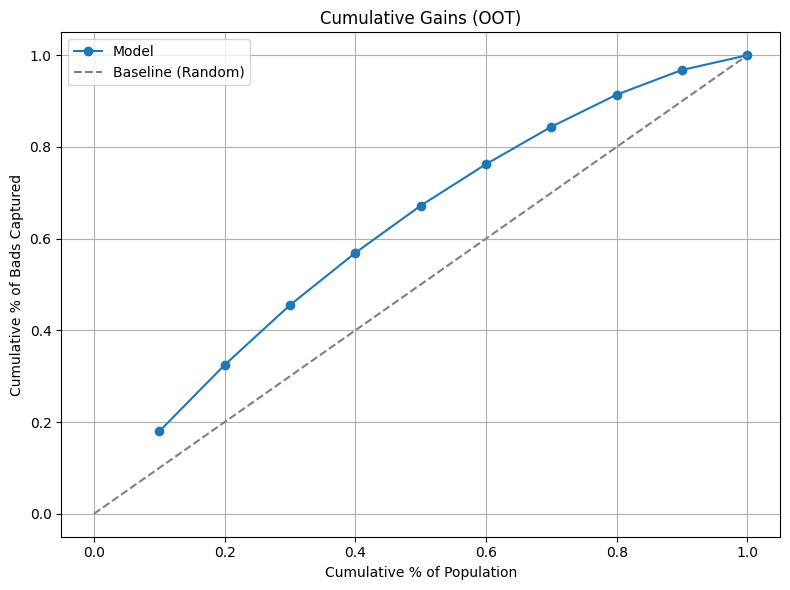

In [44]:
import matplotlib.pyplot as plt

# Example data
cum_pct_pop = summary['cum_pct_pop']
gain = summary['gain']

plt.figure(figsize=(8, 6))
plt.plot(cum_pct_pop, gain, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline (Random)')
plt.xlabel('Cumulative % of Population')
plt.ylabel('Cumulative % of Bads Captured')
plt.title('Cumulative Gains (OOT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The cumulative gains chart for the OOT sample shows the model successfully prioritises risk: the lowest 30% of the scored population accounts for ~45% of all defaults. 

This demonstrates the model’s ability to rank-order risk effectively and can be used to support downstream decision-making strategies (e.g., referrals or automated approvals).

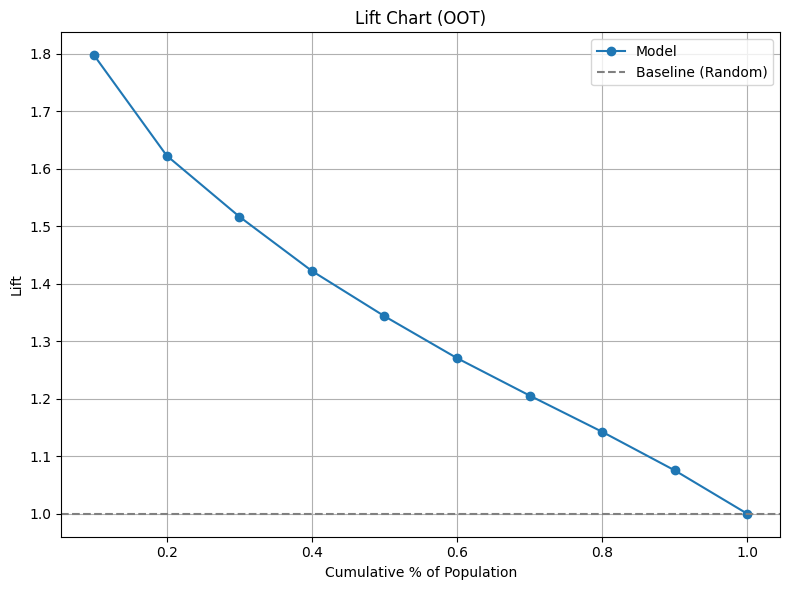

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(summary['cum_pct_pop'], summary['lift'], marker='o', label='Model')
plt.axhline(y=1, color='gray', linestyle='--', label='Baseline (Random)')

plt.title('Lift Chart (OOT)')
plt.xlabel('Cumulative % of Population')
plt.ylabel('Lift')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

* Lift at 10% of the population ≈ 1.80: the model is capturing 1.8× more bads than random selection — strong segmentation power in the top decile.
* Lift gradually declines as you include more of the population, approaching 1.0 at 100% (as expected).
* No abrupt drop - no “sweet spot” or “breakpoint” where lift collapses